In [1]:
import copy

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import tqdm.notebook as tqdm

from util.expectiles import tauspace
import imputers

from environments.igt import IowaGamblingTask, TwoStepIowaGamblingTask

EXPORT = {}

In [2]:
import pickle

def save(data, filename):
    with open(filename, 'wb') as file:
        pickle.dump(data, file)
def load(filename):
    with open(filename, 'rb') as file:
        return pickle.load(file)

In [159]:
def plot_choices(acounts):
    x = np.arange(len(acounts))
    plt.bar(x, acounts / acounts.sum())
    plt.xlabel("chosen deck")
    plt.xticks(x, "ABCD")
    plt.ylabel("percent of episodes")
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
    plt.show()
    print(acounts)
    
def train(env, agent, episodes=10000, render=True, log=False):
    acounts = np.zeros(4)
    if log: history = [agent.state()]
    for _ in tqdm.trange(episodes, unit="eps"):
        s = env.reset()
        done = False
        if render: env.render()
        while not done:
            a = agent.action(s)
            acounts[a] += 1 * (not s)
            s_, r, done, _ = env.step(a)
            agent.update(s, a, r, s_, done)
            s = s_
            if render: env.render()
        if log: history.append(agent.state())
    plot_choices(acounts)
    if log: return history

def experiment_igt(agent_class, episodes=100000, igtkwargs={}, **kwargs):
    env = IowaGamblingTask(max_nrounds=1)
    agent = agent_class([env.action_space], **kwargs)
    log = train(env, agent, episodes=episodes, render=False, log=True)
    return log

def experiment_igt2(agent_class, episodes=100000, igtkwargs={}, **kwargs):
    env = TwoStepIowaGamblingTask(**igtkwargs)
    agent = agent_class(env.action_spaces, **kwargs)
    log = train(env, agent, episodes=episodes, render=False, log=True)
    return log


def plot_history(axis, history, state, action, i=None):
    data = np.stack([h[state][action] for h in history])
    plot_log(axis, data.T, state, action, i=i)
    
def plot_log(axis, data, state, action, cmap=plt.cm.viridis, i=None):
    data = np.atleast_2d(data)
    cols = np.linspace(0, 1, len(data)+2)[1:-1]
    axis.set_title("state {}, action {}".format(state, action))
    axis.set_xlabel("episodes")
#     for j in range(0, len(data), max(1, len(data)//11)):
#         d = data[j]
#         axis.plot(d, color=cmap(cols[j]))
    if i is not None:
        axis.plot(data[i], color="red")

def plot_igt(history, i=None):
    fix, axes = plt.subplots(1, 4, figsize=(14, 3), sharey='row')
    s = 0
    for a in range(4):
        plot_history(axes[a], history, state=s, action=a, i=i)
    plt.show()
    
def plot_igt2(history, n_steps=2, i=None, height=3):
    fix, axes = plt.subplots(n_steps, 4, figsize=(14, height*n_steps), sharey='row')
    for a in range(4):
        plot_history(axes[0, a], history, state=0, action=a, i=i)
        for j in range(n_steps-1):
            plot_history(axes[j+1, a], history, state=1+a+4*j, action=0, i=i)
    plt.tight_layout()
    plt.show()

In [149]:
class QLearning:
    def __init__(self, action_spaces, ε=0.2, α=0.001, γ=1.0, random_state=None):
        self.Q = {s: np.zeros(action_spaces[s].size) for s in range(len(action_spaces))}
        self.α = α
        self.γ = γ
        self.ε = ε
        self.rng = np.random.default_rng(seed=random_state)
    def action(self, s):
        exploring = (self.rng.random() < self.ε)
        if exploring:
            return np.random.choice(self.Q[s].size)
        else:
            return np.argmax(self.Q[s])
    def update(self, s, a, r, s_, terminal):
        if terminal:
            # no next state
            self.Q[s][a] += self.α * (r - self.Q[s][a])
        else:
            a_ = np.argmax(self.Q[s_])
            self.Q[s][a] += self.α * (r + self.γ*self.Q[s_][a_] - self.Q[s][a])
    def state(self):
        return copy.deepcopy(self.Q)

In [150]:
class ExpectileQLearning:
    def __init__(self, action_spaces, n_expectiles, imputer, ε=0.2, α=0.001, γ=1.0,
                 random_state=None, lrm=False):
        self.k = n_expectiles
        self.τ = tauspace(self.k)
        self.i = self.k // 2
        self.E = {s: np.stack([np.linspace(0, 1, self.k) for _ in action_spaces[s]])
                  for s in range(len(action_spaces))}
        self.I = imputer
        self.α = α
        self.γ = γ
        self.ε = ε
        self.rng = np.random.default_rng(seed=random_state)
        if lrm:
            self.lrm = 1/np.sqrt(self.τ * (1-self.τ))
        else:
            self.lrm = 2
    def action(self, s):
        exploring = (self.rng.random() < self.ε)
        if exploring:
            return np.random.choice(self.E[s].shape[0])
        else:
            return np.argmax(self.E[s][:, self.i])
    def update(self, s, a, r, s_, terminal):
        # transform
        if terminal:
            X = r * np.ones_like(self.τ)
        else:
            a_ = np.argmax(self.E[s_][:, self.i])
            X = r + self.γ * self.I.fit(self.E[s_][a_], self.τ).sample(self.k)
        # step towards target expectiles according to ER loss
        rpe = X[:, np.newaxis] - self.E[s][a]
        scale = np.abs((rpe < 0) - self.τ)
        self.E[s][a] += self.α * self.lrm / self.k * np.sum(scale * rpe, axis=0)
    def state(self):
        return copy.deepcopy(self.E)

In [151]:
class IncompleteExpectileQLearning:
    def __init__(self, action_spaces, asymmetries, i, imputer, ε=0.2, α=0.001, γ=1.0,
                 random_state=None, lrm=False, n_sample=None):
        self.τ = np.array(asymmetries)
        self.k = asymmetries.size
        self.i = i
        self.E = {s: np.stack([np.linspace(0, 1, self.k) for _ in action_spaces[s]])
                  for s in range(len(action_spaces))}
        self.I = imputer
        self.α = α
        self.γ = γ
        self.ε = ε
        self.rng = np.random.default_rng(seed=random_state)
        self.K = n_sample if n_sample is not None else self.k
        if lrm:
            self.lrm = 1/np.sqrt(self.τ * (1-self.τ))
        else:
            self.lrm = 2
    def action(self, s):
        exploring = (self.rng.random() < self.ε)
        if exploring:
            return np.random.choice(self.E[s].shape[0])
        else:
            return np.argmax(self.E[s][:, self.i])
    def update(self, s, a, r, s_, terminal):
        # transform
        if terminal:
            X = r * np.ones_like(self.τ)
        else:
            a_ = np.argmax(self.E[s_][:, self.i])
            X = r + self.γ * self.I.fit(self.E[s_][a_], self.τ).sample(self.K)
        # step towards target expectiles according to ER loss
        rpe = X[:, np.newaxis] - self.E[s][a]
        scale = np.abs((rpe < 0) - self.τ)
        self.E[s][a] += self.α * self.lrm / self.k * np.sum(scale * rpe, axis=0)
    def state(self):
        return copy.deepcopy(self.E)

def positive_only_args(k=101):
    return {'asymmetries': tauspace(k)[k//2:],   'i': 0}
def negative_only_agent(k=101):
    return {'asymmetries': tauspace(k)[:k//2+1], 'i': k//2}

## IGT (multi-armed bandit environment)

### Traditional Q Learning

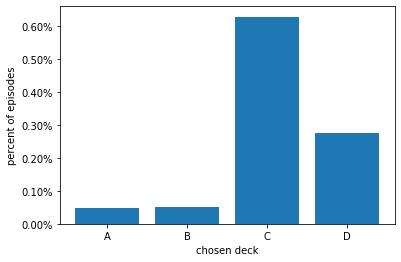

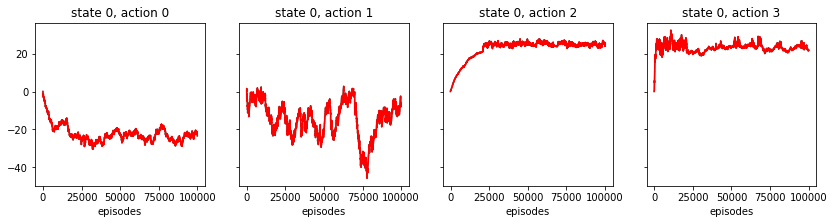

In [51]:
trad_igt = experiment_igt(QLearning)
plot_igt(trad_igt, i=0)

### Opt-based imputer

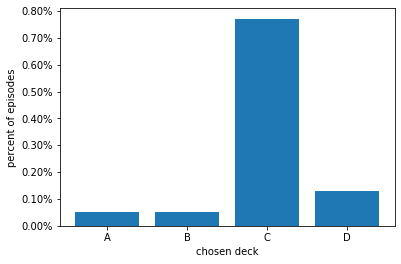

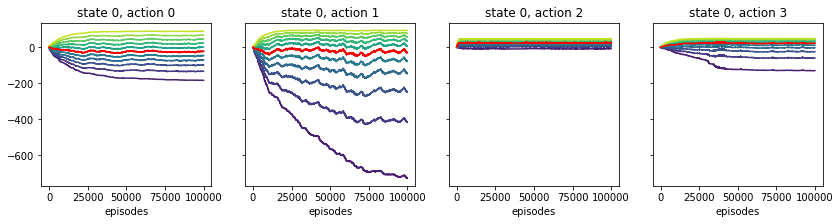

In [52]:
dist_igt = experiment_igt(ExpectileQLearning, n_expectiles=11, imputer=imputers.OptBasedImputer())
plot_igt(dist_igt, i=5)

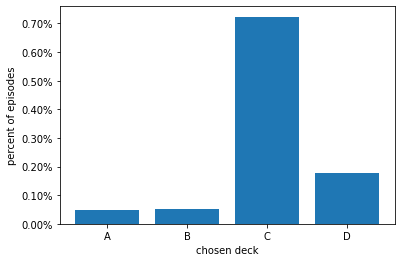

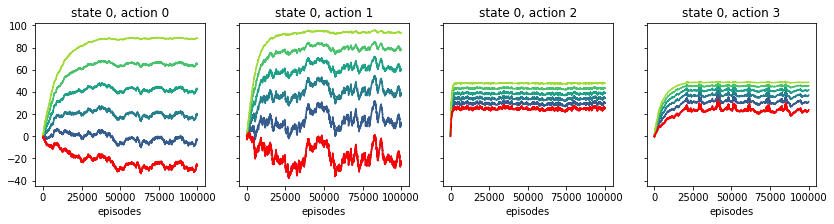

In [54]:
half_igt = experiment_igt(IncompleteExpectileQLearning,
                          imputer=imputers.OptBasedImputer(), 
                          **positive_only_args(11))
plot_igt(half_igt, i=0)

### Direct imputer

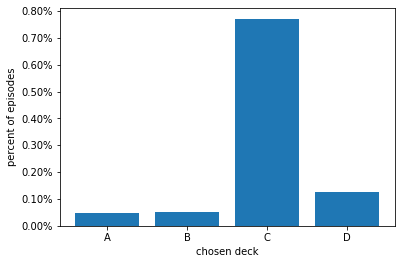

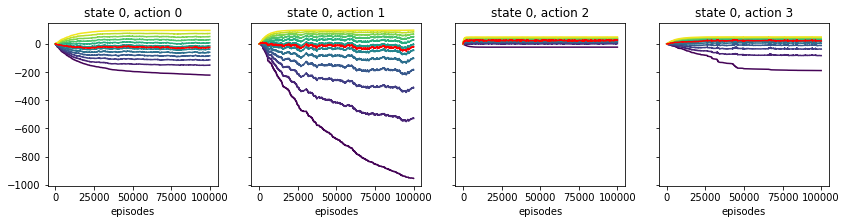

In [55]:
full_igt_direct_101 = experiment_igt(ExpectileQLearning, n_expectiles=101,
            imputer=imputers.DirectImputer(smooth_invert=True, exp_tails=True),
            )
plot_igt(full_igt_direct_101, i=50)

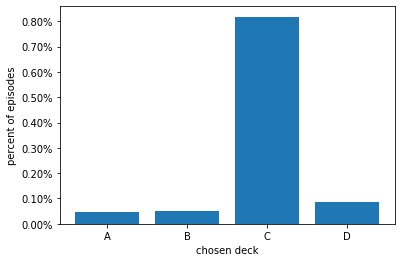

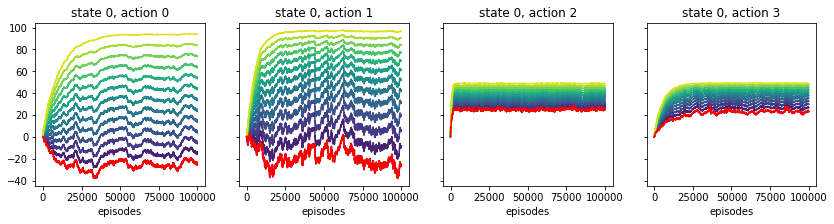

In [56]:
half_igt_direct_101 = experiment_igt(IncompleteExpectileQLearning,
                imputer=imputers.DirectImputer(smooth_invert=True, exp_tails=True),
                **positive_only_args(101)
            )
plot_igt(half_igt_direct_101, i=0)

## Two-step IGT

### Traditional Q Learning

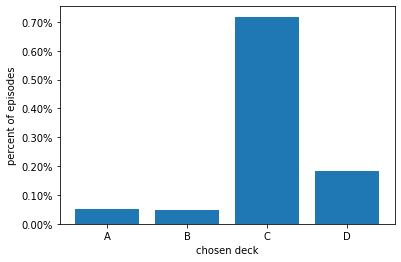

[ 10086.   9882. 143574.  36458.]


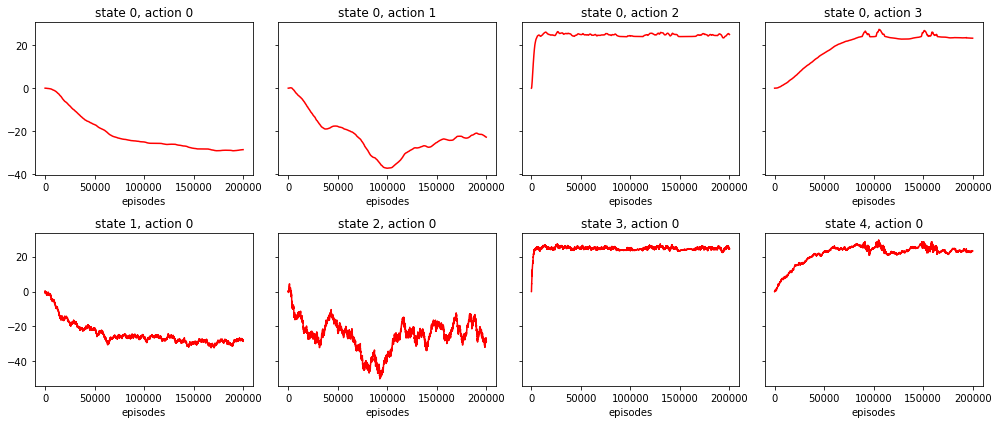

In [161]:
trad_igt2 = experiment_igt2(QLearning, episodes=200000)
plot_igt2(trad_igt2, i=0)

### Opt-based Imputer

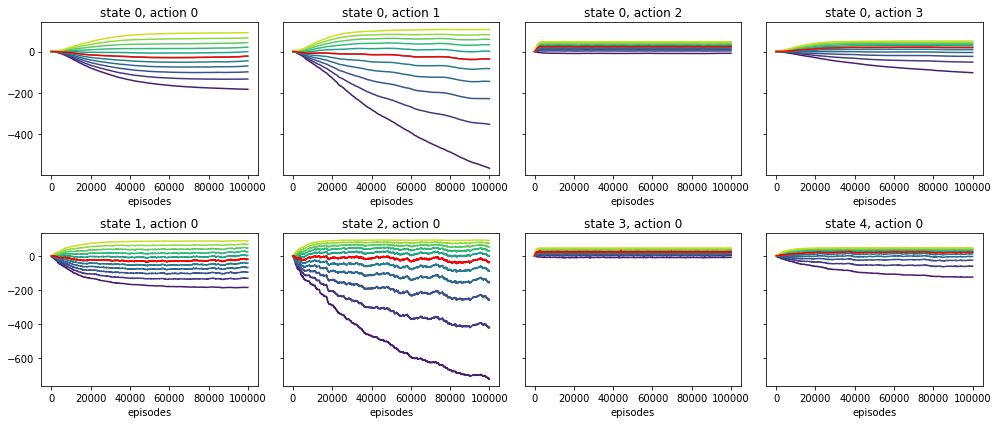

In [62]:
# dist_igt2 = experiment_igt2(ExpectileQLearning, n_expectiles=11, imputer=imputers.OptBasedImputer())
# save(dist_igt2, 'data/dist_igt2.history')
dist_igt2 = load('data/dist_igt2.history')
plot_igt2(dist_igt2, i=5)

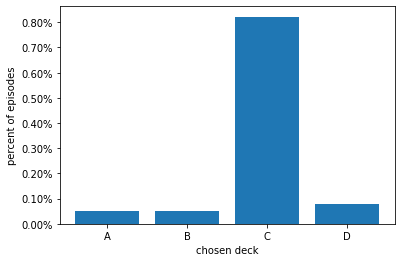

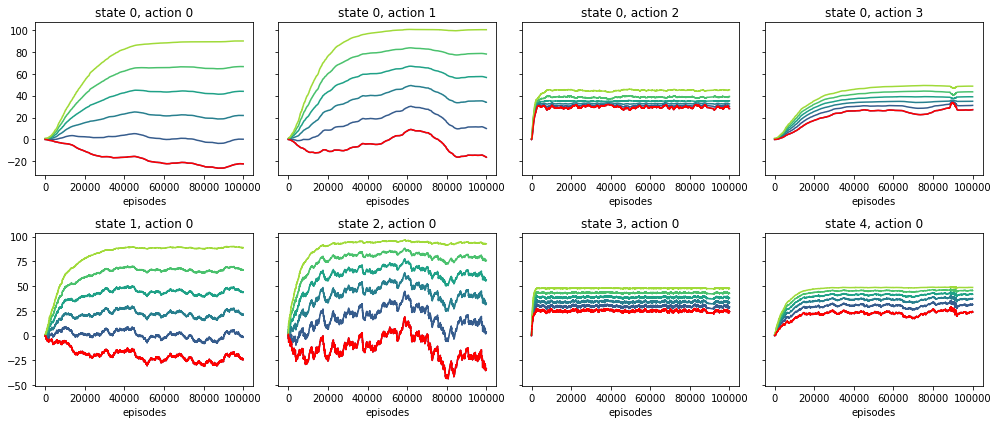

In [68]:
half_igt2 = experiment_igt2(IncompleteExpectileQLearning,
                imputer=imputers.OptBasedImputer(),
                **positive_only_args(11))
save(half_igt2, 'data/half_igt2.history')
# half_igt2 = load('data/half_igt2.history')
plot_igt2(half_igt2, i=0)

In [ ]:
# half_igt2_21 = experiment_igt2(positive_only_agent(I=imputers.OptBasedImputer(), k=21))
# save(half_igt2_21, 'data/half_igt2_21.history')
# half_igt2_21 = load('data/half_igt2_21.history')

In [ ]:
# plot_igt2(half_igt2_21, i=0)

### Direct imputer

/Users/matt/Code/nsproj/imputers.py:19: RuntimeWarning: invalid value encountered in true_divide
  W /= W.sum(axis=-1, keepdims=True)


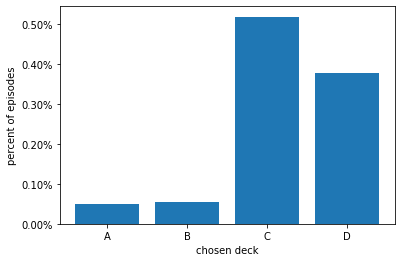

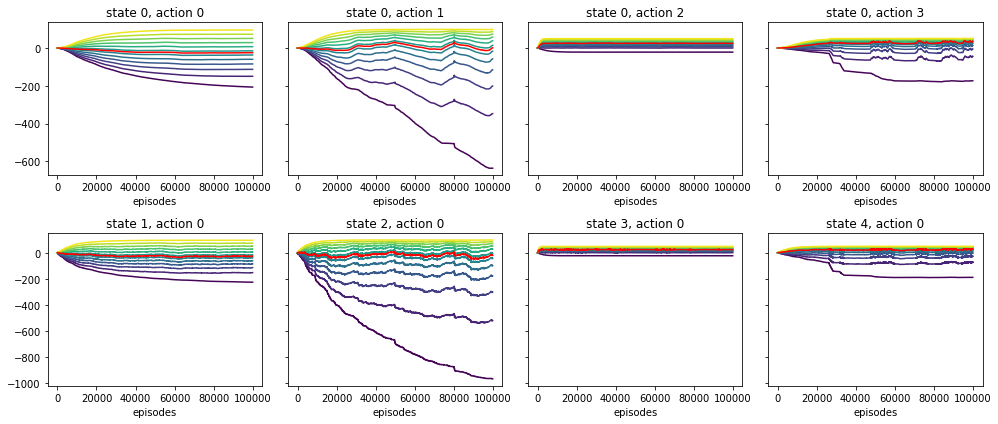

In [69]:
full_igt2_direct_101 = experiment_igt2(ExpectileQLearning,
            imputer=imputers.DirectImputer(smooth_invert=True, exp_tails=True),
            n_expectiles=101
        )
plot_igt2(full_igt2_direct_101, i=50)

/Users/matt/Code/nsproj/imputers.py:144: RuntimeWarning: divide by zero encountered in true_divide
  self.F = F = N / D
/Users/matt/Code/nsproj/imputers.py:19: RuntimeWarning: invalid value encountered in true_divide
  W /= W.sum(axis=-1, keepdims=True)


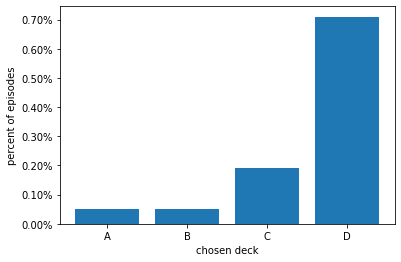

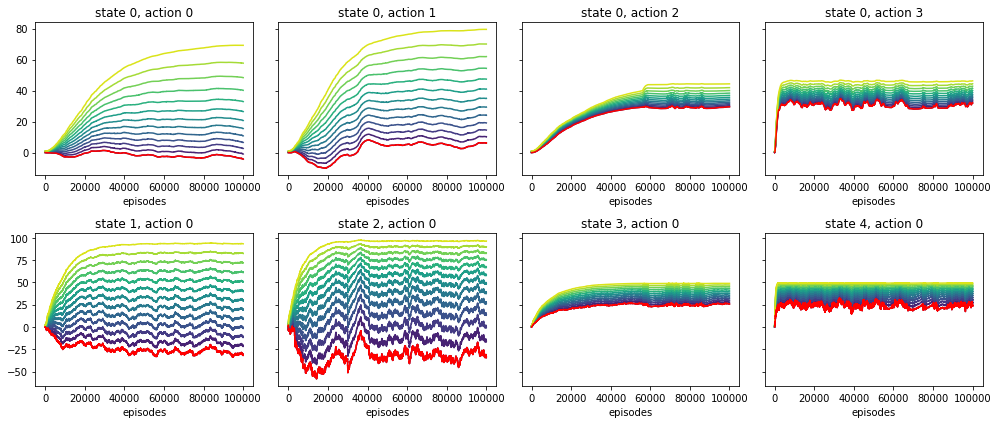

In [70]:
half_igt2_direct_101 = experiment_igt2(IncompleteExpectileQLearning,
                imputer=imputers.DirectImputer(smooth_invert=True, exp_tails=True),
                **positive_only_args(101))
plot_igt2(half_igt2_direct_101, i=0)

### More extreme version of task

In [146]:
class RewardSchemeRExtreme:
    def __init__(self, random_seed=None):
        self.pos = np.array([100, 125, 50, 50])
        self.neg = np.array([
            [0, -150, -200, -250, -300, -350],
            [0, -1250],
            [0, -50],
            [0, -250],
        ])
        self.prs = np.array([
            [0.5, 0.1, 0.1, 0.1, 0.1, 0.1],
            [0.9, 0.1],
            [0.5, 0.5],
            [0.9, 0.1],
        ])
        self.rng = np.random.default_rng(seed=random_seed)
    def reset(self):
        pass
    def rewards(self, action):
        a = "ABCD".index(action)
        return (self.pos[a], self.rng.choice(self.neg[a], p=self.prs[a]))
    def __str__(self):
        return "Scheme R-EXTREME"

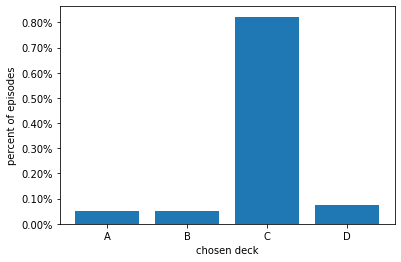

[ 10089.  10142. 164585.  15184.]


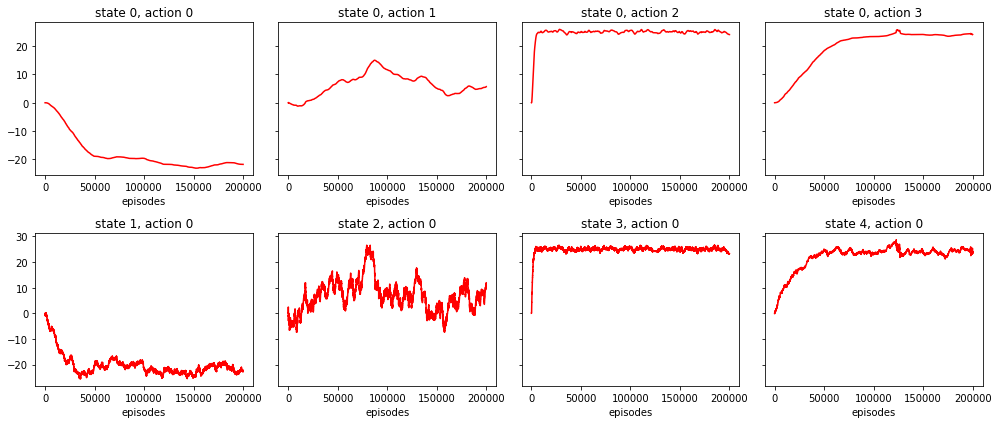

In [162]:
trad_igt2x = experiment_igt2(QLearning,
                igtkwargs={'scheme': RewardSchemeRExtreme()},
                episodes=200000)
plot_igt2(trad_igt2x, i=0, height=3)

/Users/matt/Code/nsproj/imputers.py:19: RuntimeWarning: invalid value encountered in true_divide
  W /= W.sum(axis=-1, keepdims=True)


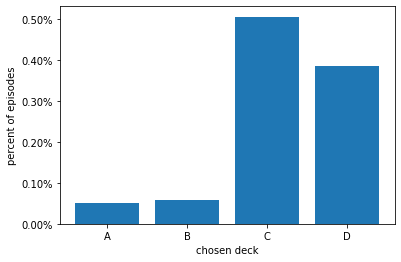

[ 10074.  11660. 101282.  76984.]


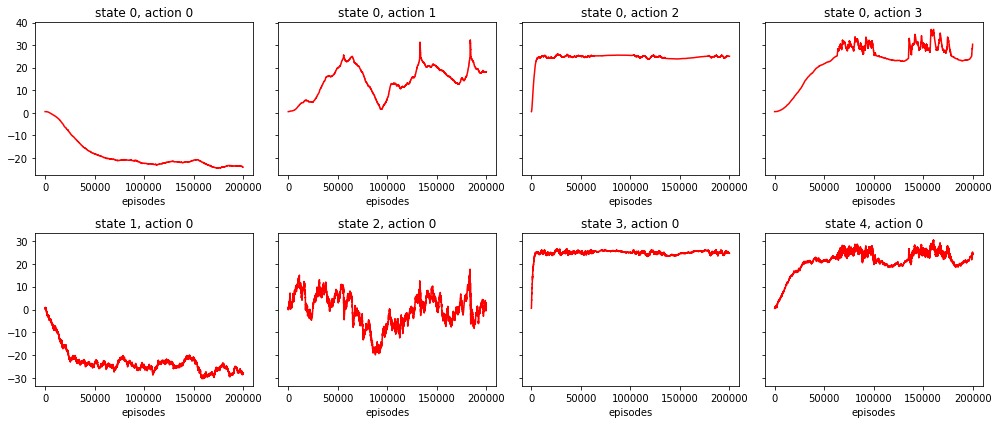

In [165]:
full_igt2x = experiment_igt2(
                ExpectileQLearning,
                n_expectiles=101,
                imputer=imputers.DirectImputer(smooth_invert=True, exp_tails=True),
                igtkwargs={'scheme': RewardSchemeRExtreme()},
                episodes=200000
                )
plot_igt2(full_igt2x, i=50)

/Users/matt/Code/nsproj/imputers.py:144: RuntimeWarning: divide by zero encountered in true_divide
  self.F = F = N / D
/Users/matt/Code/nsproj/imputers.py:19: RuntimeWarning: invalid value encountered in true_divide
  W /= W.sum(axis=-1, keepdims=True)


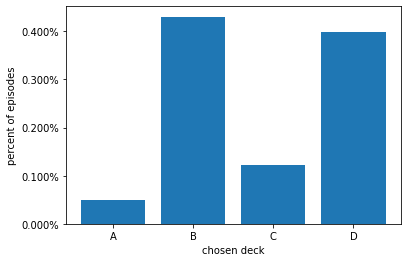

[ 9738. 86060. 24480. 79722.]


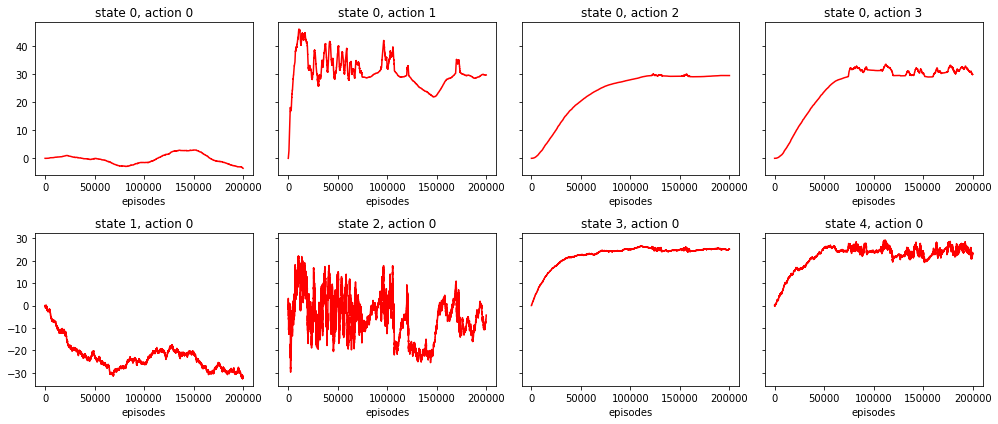

In [164]:
half_igt2x = experiment_igt2(IncompleteExpectileQLearning,
                imputer=imputers.DirectImputer(smooth_invert=True, exp_tails=True),
                **positive_only_args(101),
                igtkwargs={'scheme': RewardSchemeRExtreme()},
                episodes=200000
                )
plot_igt2(half_igt2x, i=0)

In [177]:
def extract_log(log, i=None):
    final = log[-1]
    if i is not None:
        return {
            'A1': final[0][0][i],
            'A2': final[1][0][i],
            'B1': final[0][1][i],
            'B2': final[2][0][i],
            'C1': final[0][2][i],
            'C2': final[3][0][i],
            'D1': final[0][3][i],
            'D2': final[4][0][i],
        }
    else:
        return {
            'A1': final[0][0],
            'A2': final[1][0],
            'B1': final[0][1],
            'B2': final[2][0],
            'C1': final[0][2],
            'C2': final[3][0],
            'D1': final[0][3],
            'D2': final[4][0],
        }
EXPORT_IGT = {
    'traditional action counts':   [10086, 9882, 143574, 36458],
    'traditional':      extract_log(trad_igt2),
    'opt-based':        extract_log(dist_igt2, i=5),
    'opt-based (half)': extract_log(half_igt2, i=0),
    'direct':           extract_log(full_igt2_direct_101, i=50),
    'direct (half)':    extract_log(half_igt2_direct_101, i=0),
}
EXPORT_XIGT = {
    'traditional action counts':   [ 10089,  10142, 164585,  15184],
    'direct action counts':        [ 10074,  11660, 101282,  76984],
    'direct (half) action counts': [  9738,  86060,  24480,  79722],
    'traditional':      extract_log(trad_igt2x),
    'direct':           extract_log(full_igt2x, i=50),
    'direct (half)':    extract_log(half_igt2x, i=0),
}
save(EXPORT_IGT, 'data/igt-data.pkl')
save(EXPORT_XIGT, 'data/xigt-data.pkl')